In [7]:
import pandas as pd
import numpy as np
import _pickle as pkl
from sklearn.model_selection import train_test_split

df = pd.read_csv('./datasets/train.csv')
print(df.head(5))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


### Read and Split Data

In [8]:
print("Label:\n", df.loc[0, 'Popularity'])
print("Content:\n",df.loc[0,'Page content'])

Label:
 -1
Content:
 <html><head><div class="article-info"> <span class="byline basic">Clara Moskowitz</span> for <a href="/publishers/space-com/">Space.com</a> <time datetime="Wed, 19 Jun 2013 15:04:30 +0000">2013-06-19 15:04:30 UTC</time> </div></head><body><h1 class="title">NASA's Grand Challenge: Stop Asteroids From Destroying Earth</h1><figure class="article-image"><img class="microcontent" data-fragment="lead-image" data-image="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg" data-micro="1" data-url="http://mashable.com/2013/06/19/nasa-grand-challenge-asteroid/" src="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg"/></figure><article data-channel="world"><section class="article-content"> <p>There may be killer asteroids headed for Earth, and NASA has decided to do something about it. The space agency announced a new "Grand Challenge" on June 18 to find all dangerous space rocks

In [9]:
X = df.loc[:, 'Page content'].to_numpy()
y = df.loc[:,'Popularity'].to_numpy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

print(X_train.shape)
print(y_train.shape)
print("Label:\n", y_train[0])
print("Content:\n", X_train[0])

(22114,)
(22114,)
Label:
 -1
Content:
 <html><head><div class="article-info"><span class="byline "><a href="/author/emily-banks/"><img alt="Default-m" class="author_image" src="http://i.amz.mshcdn.com/raEPzavg65Jzvjy-L4U699QBlmQ=/90x90/default-m.jpg"/></a><span class="author_name">By <a href="/author/emily-banks/">Emily Banks</a></span><time datetime="Fri, 01 Mar 2013 14:53:58 +0000">2013-03-01 14:53:58 UTC</time></span></div></head><body><h1 class="title">Mason Out at Groupon and More News You Need to Know</h1><figure class="article-image"></figure><article data-channel="business"><section class="article-content"> <div class="shift-to-hero"><div class="content-mash-video" data-autoplay="" data-embedurl="http://mashable.com/videos/embed?video=uGc7uydu&amp;player=offsite" data-labels='["Advertising", "Andrew Mason", "CEO", "Facebook", "Groupon", "adidas", "atlas", "college basketball", "first to know", "microsoft", "newsy", "twitter"]' data-playlist="http://content.jwplatform.com/manife

### Feature Engineering

In [10]:
import re
from bs4 import BeautifulSoup
from collections import Counter
from string import punctuation
from scipy.sparse import hstack
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [11]:
from collections import Counter
from string import punctuation

soup = BeautifulSoup(X[70], 'html.parser')
print(soup.prettify())

# Title
print("Title: ", soup.find("h1", {"class": "title"}).text)

# Channel
print("Data Channel: ", soup.find("article").get("data-channel"))

# Author
author_re = r'(By\s|^)(.*?)(?=\d{4}-\d{2}-\d{2}|$)'
if soup.head.find("span") == None:
    print("Author: None")
else:
    print("Author: ", re.search(author_re, soup.head.find("span").text).group(1))

# Related Topics
print("Topics: ", soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(","))

# Time
print("Time: ", re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5])

# Weekend
print("Weekend: ", int(soup.time.get("datetime")[:3] in ["Sat", "Sun"]))

# Word Count
text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
total = c_div + c_p
print("Total words: ", len(list(total.elements())))


section = soup.find("section", {"class": "article-content"})

# Video + Image count
img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
media_count = img_count + video_count
print("Media count: ", media_count)

# Appealing count
link_count = len(section.find_all("a"))
strong_count = len(section.find_all("strong"))
appealing_count = link_count + strong_count
print("Link count: ", appealing_count)


<html>
 <head>
  <div class="article-info">
   <a href="/publishers/businessnewsdaily/">
    BusinessNewsDaily
   </a>
   <time datetime="Mon, 20 Jan 2014 18:00:42 +0000">
    2014-01-20 18:00:42 UTC
   </time>
  </div>
 </head>
 <body>
  <h1 class="title">
   Senior Employees Are a Firm's Biggest Cybersecurity Weakness
  </h1>
  <figure class="article-image">
   <img alt="An Apple employee demonstrates the new iPad Mini in San Francisco on Oct. 22, 2013." class="microcontent" data-fragment="lead-image" data-image="http://i.amz.mshcdn.com/bROTa4dc55oQPOJWN72dq2rv6Lk=/950x534/2014%2F01%2F20%2Fc4%2FiPadMini.f3d59.jpg" data-micro="1" data-url="http://mashable.com/2014/01/20/cybersecurity-threat-survey/" src="http://i.amz.mshcdn.com/bROTa4dc55oQPOJWN72dq2rv6Lk=/950x534/2014%2F01%2F20%2Fc4%2FiPadMini.f3d59.jpg"/>
   <figcaption class="image-caption">
    An Apple employee demonstrates the new iPad Mini in San Francisco on Oct. 22, 2013.
   </figcaption>
   <div class="image-credit">
    Ima

### Features 

In [12]:
def feature_selection_author(text):
    feature_str = ""
    soup = BeautifulSoup(text, 'html.parser')
    # Author formate may various from news website
    author = soup.find("span", {"class": "author_name"}) # default format
    if(author != None): 
        feature_str += author.text.replace("By ", "") + " "
    elif(soup.find("span") != None): 
        feature_str += soup.find("span").text + " "
    elif(soup.find("a") != None): 
        feature_str += soup.find("a").text + " "
    feature_str = re.sub(r'[\W]+', ' ', feature_str.lower())
    return feature_str

def feature_selection_titles(text):
    feature_str = ""
    soup = BeautifulSoup(text, 'html.parser')
    feature_str += soup.find("h1", {"class": "title"}).text + " "
    feature_str = re.sub(r'[\W]+', ' ', feature_str.lower())
    return feature_str

def feature_selection_channels(text):
    feature_str = ""
    soup = BeautifulSoup(text, 'html.parser')
    feature_str += soup.find("article").get("data-channel") + " "
    feature_str = re.sub(r'[\W]+', ' ', feature_str.lower())
    return feature_str

def feature_selection_topic(text):
    feature_str = ""
    soup = BeautifulSoup(text, 'html.parser')
    feature_str += soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").replace(",", "")
    feature_str = re.sub(r'[\W]+', ' ', feature_str.lower())
    return feature_str

def extract_weekend(text):
    soup = BeautifulSoup(text, 'html.parser')
    ret = 0
    if soup.time.text == None or soup.time.text == "":
        ret = 0
    else:
        if soup.time.get("datetime")[:3] in ["Sat", "Sun"]:
            ret = 1 
        else:
            ret = 0
    return ret

def extract_word_count(text):
    soup = BeautifulSoup(text, 'html.parser')
    # Word Count
    text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
    c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
    text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
    c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
    total = c_div + c_p
    return len(list(total.elements()))

def extract_media_count(text):
    soup = BeautifulSoup(text, 'html.parser')
    section = soup.find("section", {"class": "article-content"})
    img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
    video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
    media_count = img_count + video_count
    return media_count

def extract_appealing_count(text):
    soup = BeautifulSoup(text, 'html.parser')
    section = soup.find("section", {"class": "article-content"})
    link_count = len(section.find_all("a"))
    strong_count = len(section.find_all("strong"))
    appealing_count = link_count + strong_count
    return appealing_count



### Features Selection

In [13]:
# nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_author = TfidfVectorizer(ngram_range=(1,2),
                        preprocessor=feature_selection_author,
                        tokenizer=tokenizer_stem_nostop)
tfidf_channel = TfidfVectorizer(ngram_range=(1,2),
                        preprocessor=feature_selection_channels,
                        tokenizer=tokenizer_stem_nostop)
tfidf_title = TfidfVectorizer(ngram_range=(1,2),
                        preprocessor=feature_selection_titles,
                        tokenizer=tokenizer_stem_nostop)
tfidf_topic = TfidfVectorizer(ngram_range=(1,2),
                        preprocessor=feature_selection_topic,
                        tokenizer=tokenizer_stem_nostop)

tfidf_author.fit(X_train)
tfidf_channel.fit(X_train)
tfidf_title.fit(X_train)
tfidf_topic.fit(X_train)

top = 10
# get idf score of vocabularies
idf = tfidf_title.idf_
print('[Title vocabularies with smallest idf scores]')
sorted_idx = idf.argsort()

for i in range(top):
    # When sklearn version <= 0.24.x, should use get_feature_names()
    # When sklearn version >= 1.0.x, should use get_feature_names_out()
    print('%s: %.2f' %(tfidf_title.get_feature_names_out()[sorted_idx[i]], idf[sorted_idx[i]]))

c:\Users\johnson\.conda\envs\DL2\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[Title vocabularies with smallest idf scores]
new: 3.87
googl: 4.33
app: 4.38
video: 4.46
facebook: 4.47
twitter: 4.50
appl: 4.53
world: 4.59
game: 4.63
get: 4.67


### Combine Feature Function


In [15]:
def combine(x_batch):
    x_batch_title = tfidf_title.transform(x_batch).toarray()
    #print(x_batch_title.shape)
    x_batch_author = tfidf_author.transform(x_batch).toarray()
    #print(x_batch_author.shape)
    x_batch_topic = tfidf_topic.transform(x_batch).toarray()
    #print(x_batch_topic.shape)
    x_batch_channel = tfidf_channel.transform(x_batch).toarray()
    #print(x_batch_channel.shape)
    weekend_vectorized = np.vectorize(extract_weekend)
    x_batch_weekend = weekend_vectorized(x_batch).reshape(len(x_batch),1)
    #print(x_batch_weekend.shape)
    media_vectorized = np.vectorize(extract_media_count)
    x_batch_media = media_vectorized(x_batch).reshape(len(x_batch),1)
    #print(x_batch_media.shape)
    appealing_count_vectorized = np.vectorize(extract_appealing_count)
    x_batch_appealing = appealing_count_vectorized(x_batch).reshape(len(x_batch),1)
    #print(x_batch_appealing.shape)
    word_vectorized = np.vectorize(extract_word_count)
    x_batch_word = word_vectorized(x_batch).reshape(len(x_batch),1)
    #print(x_batch_word.shape)
    combined_x_batch = np.concatenate((x_batch_title, x_batch_author, x_batch_channel, x_batch_topic),axis=1)
    # , x_batch_weekend
    #                            , x_batch_media, x_batch_appealing, x_batch_word
    #print(combined_x_batch.shape)
    return combined_x_batch

### Model Training

In [16]:
import math

def random_mini_batches(X, Y, mini_batch_size = 64):
    m = X.shape[0]  # number of training examples
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation]
    shuffled_Y = Y[permutation]
    
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


In [17]:
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

clf = SGDClassifier(loss='log_loss', alpha=0.01, max_iter=100, tol=1e-3)
# clf = XGBClassifier()

In [18]:
train_auc, val_auc = [], []
iters = 3
batch_size = 512
classes = np.array([-1, 1])

# train_tfidf = tfidf.transform(X_train).toarray()
# valid_tfidf = tfidf.transform(X_valid).toarray()

for i in range(iters):
    print(f"epoch: {i+1}/{iters}")
    train_batches = random_mini_batches(X_train, y_train, batch_size)
    valid_batches = random_mini_batches(X_valid, y_valid, int(batch_size * 0.2))
    idx = 0
    for train_batch in train_batches:
        x_batch, y_batch = train_batch
        x_batch = combine(x_batch)
        clf.partial_fit(x_batch, y_batch, classes=classes)
        train_score = roc_auc_score(y_batch, clf.predict_proba(x_batch)[:,1])
        train_auc.append(train_score)
        print(f'[{(idx+1)*batch_size}/{X_train.shape[0]}]')
        print(f'Train score: {train_score}')
        
        x_batch, y_batch = valid_batches[idx]
        valid_score = roc_auc_score(y_batch, clf.predict_proba(combine(x_batch))[:,1])
        val_auc.append(valid_score)
        print(f'Valid score: {valid_score}')
        idx+=1

epoch: 1/3
[512/22114]
Train score: 0.854215519487486
Valid score: 0.5448594532152484
[1024/22114]
Train score: 0.8039224664224665
Valid score: 0.42183235867446395
[1536/22114]
Train score: 0.7935419847328244
Valid score: 0.541972920696325
[2048/22114]
Train score: 0.7716335877862595
Valid score: 0.535618020793223
[2560/22114]
Train score: 0.7558902520905817
Valid score: 0.4771929824561404
[3072/22114]
Train score: 0.7340533088235295
Valid score: 0.49403157489410854
[3584/22114]
Train score: 0.724055848020142
Valid score: 0.6226489028213167
[4096/22114]
Train score: 0.6949746725969854
Valid score: 0.5729166666666666
[4608/22114]
Train score: 0.7011488977618676
Valid score: 0.5316358024691358
[5120/22114]
Train score: 0.7633335879611948
Valid score: 0.5527950310559007
[5632/22114]
Train score: 0.6931894704621978
Valid score: 0.5768025078369906
[6144/22114]
Train score: 0.6730813252552383
Valid score: 0.588076923076923
[6656/22114]
Train score: 0.6555081886769307
Valid score: 0.510589141

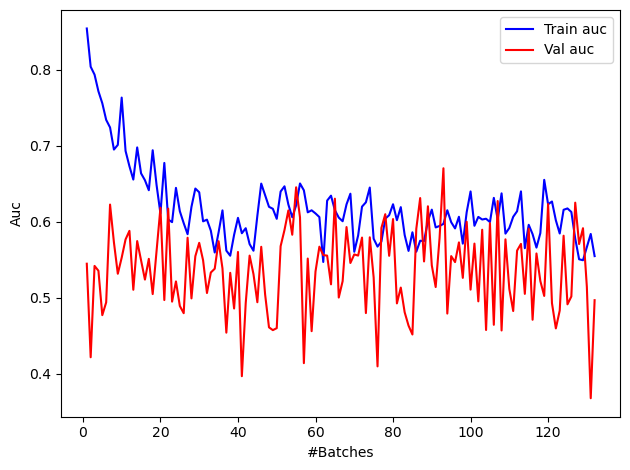

In [19]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.show()

In [25]:
# train_score = roc_auc_score(y_train, clf.predict_proba(combine(X_train))[:,1])
valid_score = roc_auc_score(y_valid, clf.predict_proba(combine(X_valid))[:,1])
# print(f'Train score: {train_score}')
print(f'Valid score: {valid_score}')

Valid score: 0.5388766271359268


### Prediction

In [21]:
df = pd.read_csv('./datasets/test.csv')
print("Content:\n",df.loc[0])

Id = df.loc[:, 'Id'].to_numpy()
X_test = df.loc[:, 'Page content'].to_numpy()
print(X_test.shape)
print("\nId:\n", Id[0])
print("Content:\n", X_test[0])

Content:
 Id                                                          27643
Page content    <html><head><div class="article-info"><span cl...
Name: 0, dtype: object
(11847,)

Id:
 27643
Content:
 <html><head><div class="article-info"><span class="byline "><a href="/author/sam-laird/"><img alt="2016%2f09%2f15%2f63%2fhttpsd2mhye01h4nj2n.cloudfront.netmediazgkymde1lza2.9814b" class="author_image" src="http://i.amz.mshcdn.com/-qaMPB8aiQeIaoBhqlU0OLjA07A=/90x90/2016%2F09%2F15%2F63%2Fhttpsd2mhye01h4nj2n.cloudfront.netmediaZgkyMDE1LzA2.9814b.jpg"/></a><span class="author_name">By <a href="/author/sam-laird/">Sam Laird</a></span><time datetime="Mon, 09 Sep 2013 19:47:02 +0000">2013-09-09 19:47:02 UTC</time></span></div></head><body><h1 class="title">Soccer Star Gets Twitter Death Threats After Tackling One Direction Member</h1><figure class="article-image"></figure><article data-channel="entertainment"><section class="article-content"> <div class="shift-to-hero"> <p><iframe allowfullscreen="" 

In [22]:
y_pred = np.around(clf.predict_proba(combine(X_test))[:,1], decimals=1)

In [23]:
output_data = {'Id': Id, 'Popularity': y_pred}
output_dataframe = pd.DataFrame(output_data)
print(output_dataframe)

output_dataframe.to_csv("./datasets/y_pred.csv", index=None)

          Id  Popularity
0      27643         0.5
1      27644         0.5
2      27645         0.5
3      27646         0.5
4      27647         0.5
...      ...         ...
11842  39485         0.5
11843  39486         0.5
11844  39487         0.5
11845  39488         0.5
11846  39489         0.5

[11847 rows x 2 columns]


In [24]:
# dump to disk
pkl.dump(clf, open('output/clf-sgd.pkl', 'wb'))